In [1]:
import torch
import matplotlib.pyplot as plt
import random

In [2]:
%matplotlib inline

In [3]:
# load dataset
path = "dataset/input.txt"
text = open(path).read()
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
block_size = 80

In [4]:
stoi = {x:i for i,x in enumerate(vocab)}
itos = {i:x for i,x in enumerate(vocab)}

In [5]:
tokenized_text = torch.tensor([stoi[x] for x in text])


In [6]:
tokenized_text.size()[0]

1115394

In [7]:
"".join([itos[int(x)] for x in tokenized_text[20:90]])

'e we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Ci'

In [8]:
dataset_size = tokenized_text.size()[0]

train_set_size = int(dataset_size*0.9)
train_set, test_set = tokenized_text[:train_set_size], tokenized_text[train_set_size:]

In [9]:
def get_batch(bs=5):
    ret = []
    for _ in range(bs):
        idx = random.randint(0, train_set.size()[0]-block_size)
        sample = tokenized_text[idx:idx+block_size]
        ret.append(sample)
    return torch.cat(ret, dim=0).view(bs, -1)

In [10]:
def encode(x):
    return torch.tensor([stoi[k] for k in x])
    
def decode(x):
    return "".join([itos[k.item()] for k in x])
    

In [11]:
decode(encode("hello"))

'hello'

In [ ]:
itos

In [59]:
decode(get_batch()[0])

' no longer, dreaming'

In [8]:
# bigram baseline
W = torch.zeros((vocab_size, vocab_size))
for x, y in zip(tokenized_text[:-1], tokenized_text[1:]):
    W[int(x), int(y)] += 1
    

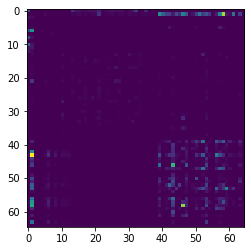

In [9]:
plt.imshow(W.numpy())

In [10]:
W = torch.zeros((vocab_size, vocab_size))

In [11]:
prompt = "H"

In [12]:
def generate(prompt, n=30):
    ret = prompt
    prev = stoi[prompt[-1]]
    
    for i in range(n):
        softmax = torch.nn.Softmax(dim=0)
        probs = torch.nn.functional.one_hot(torch.tensor(prev), num_classes=vocab_size).float() @ W
        prev = torch.multinomial(probs, 1).item()
        ret += itos[prev]
        
    return ret

In [13]:
generate("Hello", n=40)

RuntimeError: invalid multinomial distribution (sum of probabilities <= 0)

In [ ]:
torch.nn.functional.one_hot(torch.tensor(8))

In [ ]:
weight = torch.rand(8,8) 
x = torch.tensor([1,0,0,0,0,0,0,0], dtype=torch.float)
out = x @ weight
out

In [ ]:
weight[0]

In [218]:
# bigram model in more pytorchian fashion
class BigramLM(torch.nn.Module):
    def __init__(self, vocab_size):
        super(BigramLM, self).__init__()
        self.vocab_size = vocab_size
        #self.W = torch.nn.Linear(vocab_size, vocab_size, bias=None)
        self.emb = torch.nn.Embedding(vocab_size, vocab_size)
        
    def forward(self, x, targets=None):
        #x = self.W(x)
        x = self.emb(x)
        
        if targets is not None:
            B, T, C = x.shape
            logits = x.reshape(B*T, C)
            targets = targets.reshape(B*T)
            loss = torch.nn.functional.cross_entropy(logits, targets)
        else:
            loss = None
            
        return x, loss
    
    def generate(self, prompt, n_iters=80):
        idx = torch.tensor([prompt[-1]])
        
        for _ in range(n_iters):
            preds, _ = self(idx)
            probs = torch.softmax(preds, dim=-1)
            idx = torch.multinomial(probs, 1)
            idx = idx.flatten()

            prompt = torch.cat((prompt, idx))
        return prompt
    

In [230]:
model = BigramLM(vocab_size)

X = get_batch()   # B, T
#one_hots = torch.nn.functional.one_hot(X[:, :-1], num_classes=vocab_size).float()  # B, T, C

preds, loss = model(X[:, :-1], X[:, 1:])

prompt = encode("\n")
tok_generated_text = model.generate(prompt)
print(decode(tok_generated_text))
print()
print(loss)


rEpRvNIuZC&3sfgehu $miXCH&Xzr&-EkZ-3L:R$taYGujm;WERCbRnWTMAfqOpwbuwXqiuGr:'e,IZG

tensor(4.7949, grad_fn=<NllLossBackward0>)


In [231]:
X = get_batch()

print(decode(X[:, :-1][0]))
print(decode(X[:, 1:][0]))


inherited my very w
nherited my very wi


In [232]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [119]:
print(train_set.shape)
print(test_set.shape)

torch.Size([1003854])
torch.Size([111540])


In [123]:
test_set[:32 * (test_set.size()[0]// 32)].reshape(32, -1)

tensor([[12,  0,  0,  ...,  1, 40, 43],
        [58, 58, 43,  ...,  1, 58, 46],
        [43, 43,  1,  ..., 15, 20, 21],
        ...,
        [58, 46, 43,  ..., 56, 43,  8],
        [ 0,  0, 19,  ..., 57, 47, 56],
        [ 6,  0, 35,  ..., 46, 47, 50]])

In [ ]:
def validation_loss():
    

In [235]:
# training loop:
for e in range(10000):
    X = get_batch()
    #one_hots = torch.nn.functional.one_hot(X[:, :-1], num_classes=vocab_size).float()
    preds, loss = model(X[:, :-1], X[:, 1:])

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
    
print(loss)

tensor(2.4019, grad_fn=<NllLossBackward0>)


In [250]:
a = torch.randn(8,8)

In [251]:
torch.tril(torch.ones(8, 8)) == 0.

tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False]])

In [254]:
torch.nn.functional.softmax(a.masked_fill(torch.tril(torch.ones(8, 8)) == 0., value=float('-inf')), dim=-1)


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3287, 0.6713, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2057, 0.3554, 0.4389, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0969, 0.6325, 0.0875, 0.1830, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1568, 0.0761, 0.1015, 0.4888, 0.1768, 0.0000, 0.0000, 0.0000],
        [0.1577, 0.1174, 0.0644, 0.4913, 0.0904, 0.0789, 0.0000, 0.0000],
        [0.0197, 0.1104, 0.0345, 0.1194, 0.2567, 0.3250, 0.1342, 0.0000],
        [0.2401, 0.0213, 0.0914, 0.1876, 0.3216, 0.0673, 0.0070, 0.0636]])

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [20, 7] but got: [20, 6].

In [153]:
# lets build the transformer
class AttentionHead(torch.nn.Module):
    def __init__(self, d_model, head_size):
        super(AttentionHead, self).__init__()
        self.d_model = d_model
        self.head_size = head_size
        self.q = torch.nn.Linear(d_model, head_size, bias=False)
        self.k = torch.nn.Linear(d_model, head_size, bias=False)
        self.v = torch.nn.Linear(d_model, head_size, bias=False)

        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        
        
    def forward(self, x):
        # x is of shape B T C ( C = dim_model)
        B, T, C = x.shape
        K = self.k(x)
        Q = self.q(x)
        V = self.v(x)
        
        
        x = Q @ K.transpose(-2, -1) * self.d_model **(-1/2)    # B, T, T
        
        x = x.masked_fill(self.tril[:T, :T] == 0, value=float("-inf"))
        x = torch.nn.functional.softmax(x, dim=-1)
        
        x = x @ V
        return K
    
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads, head_size, use_flash=True):
        super(MultiHeadAttention, self).__init__()
        self.heads = torch.nn.ModuleList([AttentionHead(d_model, head_size) for _ in range(n_heads)])
        self.n_heads = n_heads 
        self.d_model = d_model
        self.head_size = head_size
                
        self.use_flash = use_flash
        
        self.attn_n = torch.nn.Linear(d_model, 3*head_size*n_heads, bias=False)
        self.proj = torch.nn.Linear(d_model, d_model, bias=False)
        
        self.resid_dropout = torch.nn.Dropout(0.1)
        self.attn_dropout = torch.nn.Dropout(0.1)
        
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
    
    def forward(self, x):
        B, T, C = x.shape
        q, k, v = self.attn_n(x).split(self.head_size*self.n_heads, dim=2)
        
        q = q.reshape(B, self.n_heads, T, self.head_size)
        k = k.reshape(B, self.n_heads, T, self.head_size)
        v = v.reshape(B, self.n_heads, T, self.head_size)
        
        if self.use_flash:
            x = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=0.1 if self.training else 0, is_causal=True)
        else:
            x = q @ k.transpose(-2, -1) * C **(-1/2)    # B, T, T
        
            x = x.masked_fill(self.tril[:T, :T] == 0, value=float("-inf"))
            x = torch.nn.functional.softmax(x, dim=-1)
        
            x = self.attn_dropout(x)
            x = x @ v
        
        x = x.reshape(B, T, C)
        x = self.proj(x)
        x = self.resid_dropout(x)
        return x #x.reshape(B, T, -1)

class FFN(torch.nn.Module):
    def __init__(self, d_model):
        super(FFN, self).__init__()
        self.fn = torch.nn.Sequential(
                torch.nn.Linear(d_model, 4*d_model),
                torch.nn.ReLU(),
                torch.nn.Linear(4*d_model, d_model), 
                torch.nn.Dropout(0.1))
        
    def forward(self, x):
        return self.fn(x)
    
class Block(torch.nn.Module):
    def __init__(self, d_model, n_heads, use_flash=True):
        super(Block, self).__init__()
        if d_model % n_heads != 0:
            print("Warning Head and model dim do not match")
            
        self.attn = MultiHeadAttention(d_model, n_heads, d_model//n_heads, use_flash=use_flash)
        self.ffn = FFN(d_model)
        self.ln1 = torch.nn.LayerNorm(d_model)
        self.ln2 = torch.nn.LayerNorm(d_model)
        #self.lm_head = torch.nn.Linear(d_model, vocab_size)
        
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

class Transformer(torch.nn.Module):
    def __init__(self, vocab_size, d_model, n_blocks=2, head_size=16, n_heads=4, use_flash=True, device=torch.device("cpu")):
        super(Transformer, self).__init__()
        self.device=device
        self.vocab_size = vocab_size
        #self.W = torch.nn.Linear(vocab_size, vocab_size, bias=None)
        self.emb = torch.nn.Embedding(vocab_size, d_model)
        self.pos_emb = torch.nn.Embedding(block_size, d_model)
        
        #self.attnhead = AttentionHead(d_model, head_size)
        
        if d_model % n_heads != 0:
            print("Warning: Head and model dim do not match")
        
        #self.multi_head_attn = MultiHeadAttention(d_model, n_heads, d_model//n_heads, use_flash=use_flash)
        self.blocks = torch.nn.Sequential(*[Block(d_model, n_heads, use_flash=use_flash) for _ in range(n_blocks)])
        self.ln = torch.nn.LayerNorm(d_model)
        
        self.lm_head = torch.nn.Linear(d_model, vocab_size)
        self.apply(self.init)
        
    
    def init(self, m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias != None:
                torch.nn.init.constant_(m.bias, 0.0)
            
        if isinstance(m, torch.nn.Embedding):
            torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
    
    def forward(self, x, targets=None, batch=True):
        #x = self.W(x)
        if batch == False:
            x = x.unsqueeze(0)
                    
        B, T = x.shape
        x = self.emb(x)

        pos_enc = self.pos_emb(torch.arange(T, device=self.device))
        x = x + pos_enc
        
        #x = self.multi_head_attn(x)
        x = self.blocks(x)
        x = self.ln(x)
        
        #x = self.attnhead(x)
        x = self.lm_head(x)
        
        if targets is not None:
            B, T, C = x.shape
            logits = x.reshape(B*T, C)
            targets = targets.reshape(B*T)
            loss = torch.nn.functional.cross_entropy(logits, targets)
        else:
            loss = None
        return x, loss
    
    def generate(self, prompt, n_iters=200):
        self.eval()
        for _ in range(n_iters):
            preds, _ = self(prompt[-block_size:], batch=False)
            probs = torch.softmax(preds, dim=-1)
            idx = torch.multinomial(probs[0, -1, :], 1)
            idx = idx.flatten()

            prompt = torch.cat((prompt, idx))
        return prompt
    

In [154]:
device = torch.device("cpu")
model = Transformer(vocab_size, n_blocks=4, d_model=32 ,head_size=8, n_heads=4, use_flash=True, device=device).to(device)


In [155]:
def get_val_loss(data):
    model.eval()
    data = (data[:block_size * (test_set.size()[0] // block_size)]
             .reshape(-1, block_size)
             .to(device))
            
    return model(data[:, :-1], data[:, 1:])[1]

In [156]:
device = torch.device("cuda")
model = Transformer(vocab_size, n_blocks=4, d_model=32 ,head_size=8, n_heads=4, use_flash=True, device=device).to(device)


X = get_batch().to(device)
print(X.shape)
#test_X = test_set[:block_size * (test_set.size()[0]// block_size)].reshape(-1, block_size).to(device)

#print(test_X.shape)
print(model(X[:, :-1], X[:, 1:])[1])
#print(model(test_X[:, :-1], test_X[:, 1:])[1])
print(get_val_loss(test_set))

prompt = encode("\n").to(device)
tok_generate_text = model.generate(prompt)
print(decode(tok_generate_text))

torch.Size([5, 80])
tensor(4.1773, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.1759, device='cuda:0', grad_fn=<NllLossBackward0>)

LUlZPlPLHigSbrl3TdJt!QIhFQtWxWB-n'YLL:Hhb-:i$qX?AQbREZCLA.RaZffVEKfXLIVStD'k3CoeP.;rZtpAPK.BOD&CkJztaeJdEF$pUI!eG-h.s:R!- XTrv
''b;bEUE?PgA:vxrK
GgVmt;D$ T;J!.uO3V?MZrwcs?Lzu;Z3B&vekJD?vOEO''teu!xvxKz


In [88]:
16*4

64

In [108]:
model.parameters

<bound method Module.parameters of Transformer(
  (emb): Embedding(65, 32)
  (pos_emb): Embedding(80, 32)
  (blocks): Sequential(
    (0): Block(
      (attn): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x AttentionHead(
            (q): Linear(in_features=32, out_features=8, bias=False)
            (k): Linear(in_features=32, out_features=8, bias=False)
            (v): Linear(in_features=32, out_features=8, bias=False)
          )
        )
        (attn_n): Linear(in_features=32, out_features=96, bias=False)
        (proj): Linear(in_features=32, out_features=32, bias=False)
        (drop_out): Dropout(p=0.1, inplace=False)
      )
      (ffn): FFN(
        (fn): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=32, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
      (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    

In [157]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
losses = []

In [158]:
# train
import time

start = time.time()

train_loss = []
model.train()
for e in range(5000):
    optimizer.zero_grad()
    X = get_batch(bs=32).to(device)

    preds, loss = model(X[:, :-1], X[:, 1:])
    train_loss.append(loss.item())

    if (e+1)%500 == 0:
        losses.append([get_val_loss(test_set).item(),
                        torch.mean(torch.tensor(train_loss)[-1000:]).item()])
        #print(get_val_loss(test_set), torch.mean(torch.tensor(losses)[-1000:]))
        print(losses[-1][0], losses[-1][1])
        
    

    loss.backward()
    optimizer.step()

end = time.time()
print(loss)

model.eval()
print("took {0:4.4f}".format(end-start))

2.040860176086426 2.3454015254974365
1.9099301099777222 2.093977689743042
1.8384230136871338 1.7801967859268188
1.802059292793274 1.6884621381759644
1.776495099067688 1.644555926322937
1.7742501497268677 1.61770498752594
1.7656103372573853 1.597503423690796
1.7451114654541016 1.5829341411590576
1.7327194213867188 1.5705877542495728
1.7505772113800049 1.5615570545196533
tensor(1.5333, device='cuda:0', grad_fn=<NllLossBackward0>)
took 47.0404


In [139]:
# time taken no flash 14.65
# time taken with flash 15.17

# validation loss with small model d_model = 32 head_size = 8

In [140]:
losses

[[2.0893301963806152, 2.3431203365325928],
 [1.9896214008331299, 2.150848627090454],
 [1.9536253213882446, 1.9087660312652588],
 [1.9321609735488892, 1.833709478378296],
 [1.913248896598816, 1.7929292917251587],
 [1.9095667600631714, 1.7657725811004639],
 [1.890507698059082, 1.7473843097686768],
 [1.8769731521606445, 1.7337236404418945],
 [1.8714709281921387, 1.7235218286514282],
 [1.8712762594223022, 1.7156797647476196]]

In [141]:
loss_history = torch.tensor(losses)
loss_history.shape

torch.Size([10, 2])

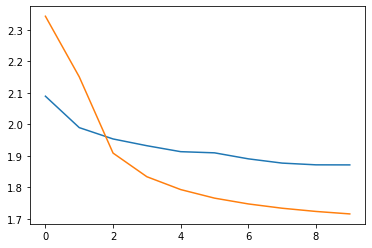

In [142]:
plt.plot(loss_history[:, 0])
plt.plot(loss_history[:, 1])

In [159]:
prompt = encode("\n").to(device)
tok_generated_text = model.generate(prompt, n_iters=800)
print(decode(tok_generated_text))


TIRICABy hell?

For RI sfanchet!
What theveaneanofor him damausthaidoisthaycinghed!

ROFOLYONCE:
Whereforiouse, to the wrenguit make I akill revenging too hafther:
Have, 'twake chasterity Cilous Laste-limbh.

YORRHAS:
Ghat to comisperet peak whosty mind He
saigch is was thee La FONTEO:
It now alone set traitor of these cave,
His comis's hatagh, where is thirk he great,
To sear, good gite: Keecutio, his sitn alone; met with thounst, welles, chois such two xispor,
It firmeriash, the eidvery I, quisepher ofuch the loling hangst condachory one
As seall forf?
But anljury

WARWICK:
I faither former Ciaugalol no revingned--

Pithnesty, Had ENhangbale! You, his compendionsmen, and.

FORD:
Why, thou before, thee wormy thou not bont the tto these comestine; I havery windren?


DUCKENCENTIO:
Ladicy'e


In [31]:
# parallel MultiHeadAttention
q = torch.randn(4, 15, 8)
k = torch.randn(4, 15, 8)
v = torch.randn(4, 15, 8)

x = torch.randn(6, 4, 5, 15)  # B, H , T, C

Q = x @ q
print(x.shape)
K = x @ k
V = x @ v

wei = Q @ K.transpose(-2, -1)

wei.shape

#wei =  q(x) @ k(x).transpose(-2, -1)
wei.masked_fill(torch.tril(torch.ones(5, 5)) == 0, value=float("-inf"))[0][0]
#torch.nn.functional.softmax(wei, dim=-1)

#((wei @ v(x)).reshape(6, 10, -1)).shape

torch.Size([6, 4, 5, 15])


tensor([[ 36.1603,     -inf,     -inf,     -inf,     -inf],
        [-12.5916,  -1.1145,     -inf,     -inf,     -inf],
        [-23.4505, -34.9204,  46.3230,     -inf,     -inf],
        [-24.8290, -11.0581, -38.6922, -23.3168,     -inf],
        [ 11.2612, -10.1524,  24.9597,  16.9123,  -1.6959]])

In [929]:
a = torch.randn(3, 4, 2)
b = torch.randn(1, 5, 4)

y1 = b @ a
y2 = torch.zeros(3, 5, 2)

for i in range(3):
    y2[i] = b[0] @ a[i]
    
torch.allclose(y2, y1)

True

In [877]:
# parallel MultiHeadAttention
q = torch.randn(15, 8)
k = torch.randn(15, 8)
v = torch.randn(15, 8)

x = torch.randn(6, 5, 15)  # B, H , T, C

Q = x @ q
K = x @ k
V = x @ v

wei = Q @ K.transpose(-2, -1)

wei.shape

#wei =  q(x) @ k(x).transpose(-2, -1)
wei.masked_fill(torch.tril(torch.ones(5, 5)) == 0, value=float("-inf"))[0]
#torch.nn.functional.softmax(wei, dim=-1)

#((wei @ v(x)).reshape(6, 10, -1)).shape

tensor([[ 23.8145,     -inf,     -inf,     -inf,     -inf],
        [-34.0588,  -1.5120,     -inf,     -inf,     -inf],
        [  8.4824, -12.2511,  -0.3416,     -inf,     -inf],
        [-22.9814,  13.8634,   8.0157,  54.3168,     -inf],
        [-23.0952, -36.7661, -44.1098, -48.8255, -26.4376]])

In [ ]:
torch.tensor

In [904]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.8584,  0.7792, -2.8490,  ...,  0.5985,  0.0632,  0.3100],
        [ 0.2491,  0.7193, -0.6177,  ..., -1.2455,  0.0323,  0.8273],
        [-0.1170, -0.7733, -0.5159,  ..., -0.6091,  0.7261, -1.7019],
        ...,
        [-0.8056, -1.0763,  0.4098,  ...,  0.4659, -1.4481, -1.7444],
        [ 0.5956, -1.7104, -2.6853,  ...,  0.6092, -0.3064, -0.9494],
        [ 1.3597,  1.0070,  2.3976,  ...,  1.2521, -0.5891, -0.2853]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.2895, -0.0591, -0.0274,  ..., -1.1045,  1.3969,  0.3599],
        [ 2.1078, -1.9776,  0.9606,  ...,  0.1297, -0.4242,  0.7378],
        [ 0.1155,  0.6638,  1.3214,  ...,  0.9679,  0.3200,  0.3237],
        ...,
        [-0.2660, -1.0125,  0.5276,  ...,  0.7452,  3.4497, -0.6088],
        [ 0.0734,  2.0302,  0.6456,  ...,  0.0857,  0.9984, -0.9216],
        [ 0.4457,  0.8862,  0.6299,  ..., -0.5963, -0.8404, -1.9163]],
       device='cuda:0', requires_grad=True)


In [905]:
X.shape

torch.Size([5, 80])

In [906]:
model.parameters

<bound method Module.parameters of Transformer(
  (emb): Embedding(65, 32)
  (pos_emb): Embedding(80, 32)
  (multi_head_attn): MultiHeadAttention()
  (lm_head): Linear(in_features=32, out_features=65, bias=True)
)>

In [984]:
losses = []

In [799]:
torch.nn.init.uniform_(torch.empty(5, 3), 0.0, 1)

tensor([[0.0654, 0.5625, 0.9809],
        [0.7649, 0.0284, 0.5907],
        [0.0445, 0.2730, 0.1248],
        [0.4442, 0.8522, 0.6855],
        [0.3698, 0.7978, 0.6498]])

In [704]:
# single attention head with size d_model = 32 d_head = 16
# loss = 2.28
# mulit head attention with size d_model 32 d_head = 16 n_heads = 4
# loss 1.97
# with parallel heads (cursed matrix multiplication)
# loss 1.54

In [980]:
loss

tensor(2.1221, grad_fn=<NllLossBackward0>)

In [136]:
torch.cat((torch.randn(1), torch.randn(1)))

tensor([-0.1698,  2.3261])

In [ ]:
model = TransformerModel()

In [ ]:
# build 

<ipython-input-31-e129a4bcfea0>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(x @ x.T) @ x


tensor([[3.5000],
        [6.4207],
        [6.8435],
        [6.9476],
        [6.9813],
        [6.9932],
        [6.9975],
        [6.9991]])